In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

from dslab_virgo_tsi.data_utils import load_data
from dslab_virgo_tsi.constants import Constants as Const

In [49]:
data_dir = "data"
virgo_file = "VIRGO_Level1.txt"
results_dir = os.path.join(data_dir, "analysis")

data = load_data(data_dir, virgo_file)

t = data[Const.T]  # Time in mission days
# t = data["timestamp"].apply(mission_day_to_year)  # Uncomment for time measured in years
pmo_a = data[Const.A]
pmo_b = data[Const.B]
temp = data[Const.TEMP]
data.sample(15, random_state=2)

,TIME,PMO6V-A,PMO6V-B,TEMPERATURE
916133,707.2037,1364.124,NaN,27.612
4540366,3224.0322,1360.755,NaN,29.833
1184820,893.7919,1363.791,NaN,26.496
1652927,1218.8662,1363.623,NaN,26.422
6541184,4613.4893,NaN,NaN,29.463
6169960,4355.6948,1360.001,NaN,31.748
9447604,6631.8364,1359.868,NaN,29.349
10494042,7358.5293,1359.368,NaN,29.713
11214199,7858.6382,1358.931,NaN,27.109
7101944,5002.9058,1359.604,NaN,28.829


In [50]:
data_nn = data[[Const.T, Const.A, Const.B]].dropna()
t_nn = data_nn[Const.T]
x_a_nn = data_nn[Const.A]
x_b_nn = data_nn[Const.B]
ratio_a_b = x_a_nn/x_b_nn

In [51]:
data = np.stack((t_nn, ratio_a_b)).T
data = data[::10]
data.shape

(2153, 2)

In [52]:
y= data[:,1]
X = data[:,0].T.reshape(-1,1)

In [73]:
y=np.concatenate(np.)

ValueError: all input arrays must have the same shape

In [71]:
np.zeros((10, 1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

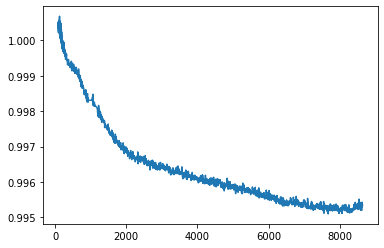

In [35]:
plt.plot(X, y)

# SVR attempt

In [9]:
from sklearn.svm import SVR

cost_param = [10**i for i in range(-2,0)]
epsilon_param = [10**i for i in range(-2, 0)]

param_grid = [
    {
        'C' : cost_param,
        'epsilon' : epsilon_param,
    },
]


grid = GridSearchCV(SVR(kernel='rbf', 
                        gamma='scale'),
                    cv=10, 
                    n_jobs=-1, 
                    param_grid=param_grid)

In [11]:
start_time = time.time()
grid.fit(X, y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.1146769523620605 seconds ---


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
clf = SVR(C=1e-3, gamma='auto', epsilon=1e-20, kernel='rbf')
clf.fit(X, y)

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=1e-20, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [13]:
clf.get_params()

{'C': 0.001,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 1e-20,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

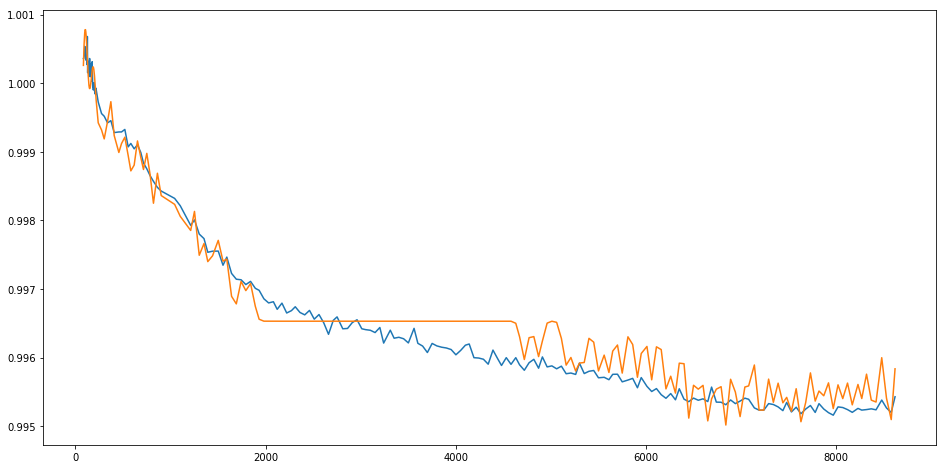

In [154]:
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, X, grid.predict(X.reshape(-1,1)))

# Gaussian processes

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared

In [12]:
kernel = 10*(WhiteKernel() * RBF() + RationalQuadratic() + ExpSineSquared())

In [13]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)

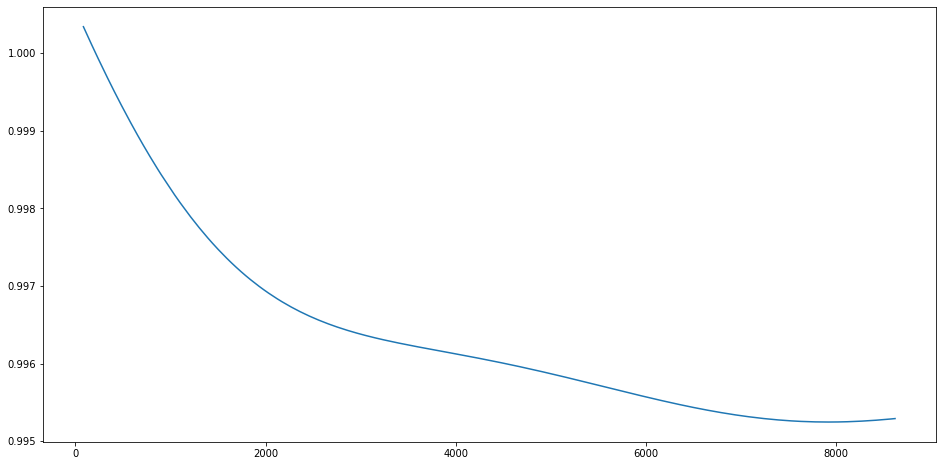

In [15]:
plt.figure(5, figsize=(16, 8))
plt.plot(X, gpr.predict(X))

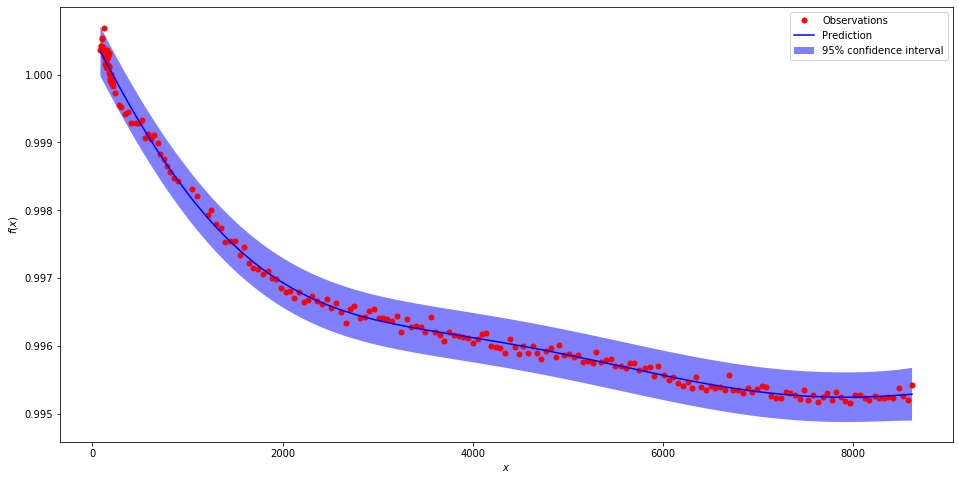

In [16]:
y_pred, sigma = gpr.predict(X, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(X, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([X, X[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
# plt.ylim(0.995, 1)
#plt.xlim(2000, 4000)
plt.legend(loc='upper right')

# Decreasing, Convex Splines through point (0,1)

In [160]:
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer

from scipy.interpolate import UnivariateSpline, splev, splrep
from scipy.optimize import minimize
import warnings

In [161]:
class DegradationSpline():
    def __init__(self, k=3, s_params=(-14,0), steps=30):
        self.k = k
        self.s_params = self._s_param_generator(*s_params)
        self.steps = steps

    def _s_param_generator(self, start, finish):
        for i in range(start, finish):
            for j in range(1, 10):
                yield j * 10 ** i

    def _guess(self, x, y, k, s, w=None):
        """Do an ordinary spline fit to provide knots"""
        return splrep(x, y, w, k=k, s=s)

    def _err(self, c, x, y, t, k, w=None):
        """The error function to minimize"""
        diff = y - splev(x, (t, c, k))
        if w is None:
            diff = np.einsum('...i,...i', diff, diff)
        else:
            diff = np.dot(diff * diff, w)
        return np.abs(diff)

    def _spline_dirichlet(self, x, y, k=3, s=0, w=None):
        t, c0, k = self._guess(x, y, k, s, w=w)
        con = {'type': 'eq',
               'fun': lambda c: splev(0, (t, c, k), der=0) - 1,
               }
        opt = minimize(self._err, c0, (x, y, t, k, w), constraints=con)
        copt = opt.x
        return UnivariateSpline._from_tck((t, copt, k))

    def _is_decreasing(self, spline, x):
        spline_derivative = spline.derivative()
        return np.all(spline_derivative(x.ravel()) < 0)

    def _is_convex(self, spline, x):
        spline_derivative_2 = spline.derivative().derivative()
        return np.all(spline_derivative_2(x.ravel()) > 0)

    def _find_convex_decreasing_spline(self, x, y):
        for s in self.s_params:
            spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=s)
            if self._is_decreasing(spline, x) and self._is_convex(spline, x):
                return spline
        raise Exception(
            'Could not find increasng and convex spline for this set of sensitivity parameters and fitting data x, y')

    def _find_convex_decreasing_spline_binary_seach(self, x, y):
        """
        for start it should be weird
        for end it should be decreasing
        """
        start = 0
        end = 1
        mid = (end - start) / 2
        spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=mid)
        step = 1
        while step <= self.steps:
            if self._is_decreasing(spline, x):
                end = mid
                mid = (end - start) / 2
                spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=mid)
            else:
                start = mid
                mid = (end - start) / 2
                spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=mid)
            step += 1
        spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=end)
        if not self._is_convex(spline, x):
            warnings.warn("Spline is decrasing but not convex.")
        return spline
    
    def test(self, x, y, s):
        spline = self._spline_dirichlet(x.ravel(), y.ravel(), k=self.k, s=s)
        print(self._is_decreasing(spline, x))
        print(self._is_convex(spline, x))
        return spline(x)
                
    def fit(self, x, y):
        self.sp = self._find_convex_decreasing_spline_binary_seach(x, y)

    def predict(self, x):
        return self.sp(x)

    
class SplineWithInitialOne: 
    def __init__(self, k=3, s=1e-3):
        self.k = k
        self.s = s
        
    def fit(self, x, y):
        self.sp = spline_dirichlet(x.ravel(), y, self.k, self.s)
        return self.sp
    
    def predict(self, x):
        return self.sp(x)
    
    def get_params(self, deep=True):
        return {'k' : self.k,
                's' : self.s}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
class ThinningFolds:
    
    def __init__(self, t=0.1):
        self.t = t
    
    def split(self, x, *params):
        l = len(x)
        n = int(1/self.t)
        for i in range(n):
            train = np.arange(i, l, n)
            test = np.array([j for j in range(l) if j % n != i])
            yield (train, test)
    
    def get_n_splits(self, x, *params):
        n = int(1/self.t)
        return n

In [162]:
model = DegradationSpline()

In [163]:
model.fit(X, y)

/Users/lenarttreven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Spline is decrasing but not convex.


In [157]:
plt.figure(5, figsize=(16, 8))
plt.plot(X.ravel(), model.predict(X.ravel()), X.ravel(), model.predict(X.ravel()))

AttributeError: 'DegradationSpline' object has no attribute 'sp'

<Figure size 1152x576 with 0 Axes>

In [158]:
model1 = DegradationSpline(s_params=(-15,0))

In [159]:
model1.fit(X[::5], y[::5])

NameError: name 'splrep' is not defined

## Isotonic regression

In [53]:
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import UnivariateSpline

In [54]:
ir = IsotonicRegression(y_max=1, increasing=False, out_of_bounds='clip')

In [55]:
ir.fit_transform(X.ravel(), y)

array([1.        , 1.        , 1.        , ..., 0.99525529, 0.99525529,
       0.99525529])

In [56]:
max_time = X.ravel()[-1]
time = np.linspace(0, max_time, 999)

In [13]:
sp = DegradationSpline()
sp.fit(time, ir.predict(time))

NameError: name 'DegradationSpline' is not defined

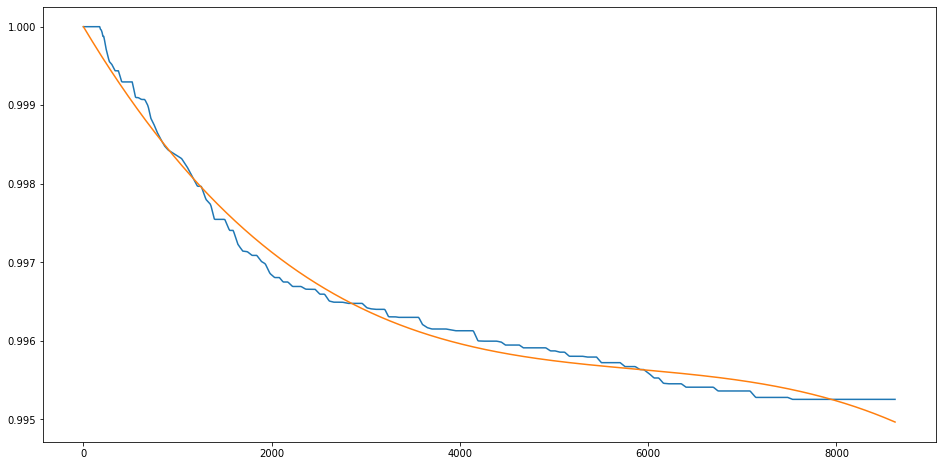

In [169]:
p = 1
plt.figure(5, figsize=(16, 8))
plt.plot(time, p* ir.predict(time) + (1-p)*model.predict(time), time, sp.predict(time))

# Gurobi Implementation

In [68]:
import gurobipy as gr

In [69]:
max_time = X.ravel()[-1]
time = np.linspace(0, max_time, 999)
y1 = ir.predict(time)

In [134]:
n = len(y1)

model = gr.Model("qp")
mu = model.addVars(n, lb=-gr.GRB.INFINITY, vtype=gr.GRB.CONTINUOUS)
model.addConstrs(mu[j+1] <= mu[j] for j in range(n-1))
model.addConstrs(mu[j] <= 1 for j in range(n))
model.addConstrs(mu[j-1] + mu[j+1] >= 2* mu[j] for j in range(1, n-1))
obj = gr.QuadExpr()

for i in range(n):
    obj += (mu[i] - y1[i]) * (mu[i] - y1[i])
for i in range(n-1):
    obj += (mu[i+1]- mu[i]) * (mu[i+1]- mu[i])

model.setObjective(obj, gr.GRB.MINIMIZE)
model.optimize()

Optimize a model with 2994 rows, 999 columns and 5986 nonzeros
Model has 1997 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+00, 2e+00]
  QObjective range [4e+00, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 999 rows and 0 columns
Presolve time: 0.01s
Presolved: 1995 rows, 999 columns, 4987 nonzeros
Presolved model has 1997 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 998
 AA' NZ     : 1.817e+04
 Factor NZ  : 3.534e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.609e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.90250670e+02 -9.99006783e+05  6.12e-01 1.00e+03  1.00e+06     0s
   1   6.57551879e+07 -6.57694339e+07  1.14e+01 1.24e+01  5.55e+04     0s
   2   1.35371337e+07 -1.35390664e+07  1.04e+00 1.10e+

In [135]:
x1 = np.array(list((map(lambda x: x.X, model.getVars()))))

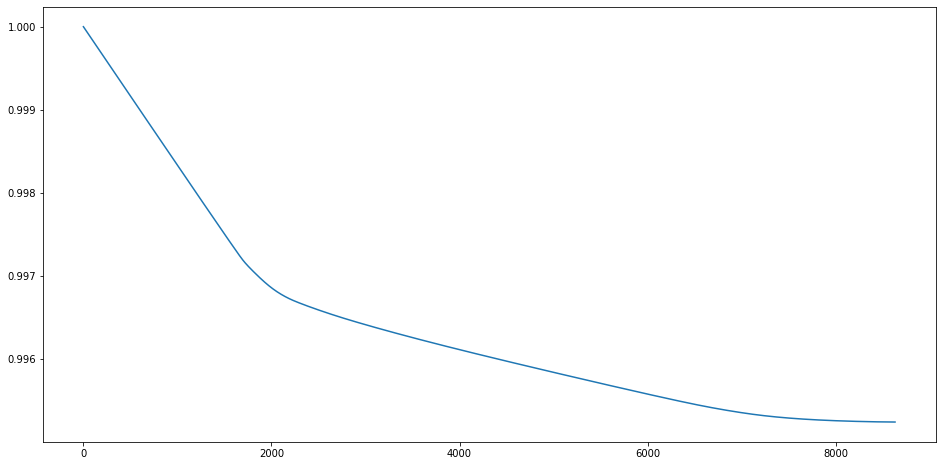

In [136]:
plt.figure(5, figsize=(16, 8))
plt.plot(time, x1)

In [57]:
import cvxpy as cp

In [155]:
max_time = X.ravel()[-1]
time = np.linspace(0, max_time, 999)
y1 = ir.predict(time)

In [156]:
n = len(y1)

In [157]:
mu = cp.Variable(n)

In [189]:
objective = cp.Minimize(cp.sum_squares(mu - y1) + cp.sum_squares(mu[:-1]-mu[1:]))

In [190]:
constraints = [mu[1:] <= mu[:-1], mu[:-2] + mu[2:] >= 2 * mu[1:-1], mu <= 1]

In [191]:
model = cp.Problem(objective, constraints)

In [192]:
model.solve(solver=cp.ECOS_BB)

1.9657142001877575e-06

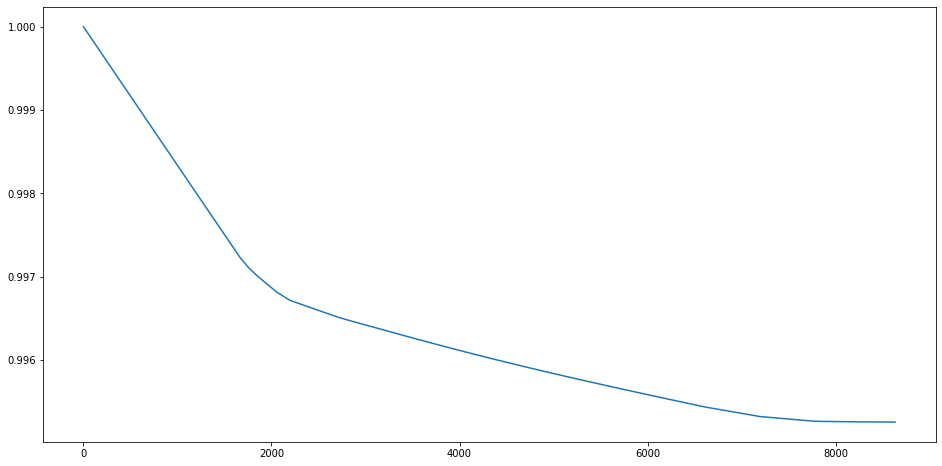

In [193]:
plt.figure(5, figsize=(16, 8))
plt.plot(time, mu.value)

In [181]:
# We have paramters time and x1 as output. To compute the value for abitrary input which differs from time, we 
# compute simple linear interpolation between the nearest points. 
from scipy.interpolate import interp1d

In [183]:
spline = interp1d(time, mu.value)

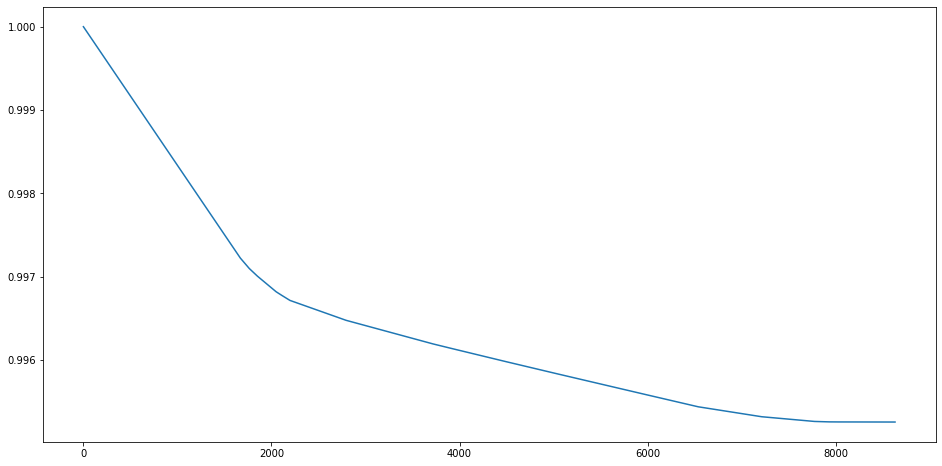

In [185]:
plt.figure(5, figsize=(16, 8))
plt.plot(time, spline(time))

In [188]:
import cvxopt